Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Tune XGBoost with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of XGBoost with a regression example.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Regression Example
### Load data and preprocess

Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=537, data_dir='./')

load dataset from ./openml_ds537.pkl
Dataset name: houses
X_train.shape: (15480, 8), y_train.shape: (15480,);
X_test.shape: (5160, 8), y_test.shape: (5160,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment.log',  # flaml log file
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 11-23 01:28:26] {1861} INFO - task = regression
[flaml.automl: 11-23 01:28:26] {1863} INFO - Data split method: uniform
[flaml.automl: 11-23 01:28:26] {1867} INFO - Evaluation method: cv
[flaml.automl: 11-23 01:28:26] {1933} INFO - Minimizing error metric: 1-r2
[flaml.automl: 11-23 01:28:26] {1985} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 11-23 01:28:26] {2223} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-23 01:28:26] {2337} INFO - Estimated sufficient time budget=1362s. Estimated necessary time budget=1s.
[flaml.automl: 11-23 01:28:26] {2417} INFO -  at 0.2s,	estimator xgboost's best error=2.1267,	best estimator xgboost's best error=2.1267
[flaml.automl: 11-23 01:28:26] {2223} INFO - iteration 1, current learner xgboost
[flaml.automl: 11-23 01:28:26] {2417} INFO -  at 0.3s,	estimator xgboost's best error=2.1267,	best estimator xgboost's best error=2.1267
[flaml.automl: 11-23 01:28:26] {2223} INFO - iteration 2, current learne

### Best model and metric

In [5]:
# retrieve best config
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1 - automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 776, 'max_leaves': 160, 'min_child_weight': 32.57408640781376, 'learning_rate': 0.034786853332414935, 'subsample': 0.9152991332236934, 'colsample_bylevel': 0.5656764254642628, 'colsample_bytree': 0.7313266091895249, 'reg_alpha': 0.005771390107656191, 'reg_lambda': 1.49126672786588}
Best r2 on validation data: 0.834
Training duration of best run: 9.471 s


In [6]:
automl.model.estimator

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.5656764254642628, colsample_bynode=1,
             colsample_bytree=0.7313266091895249, gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=0.034786853332414935,
             max_delta_step=0, max_depth=0, max_leaves=160,
             min_child_weight=32.57408640781376, missing=nan,
             monotone_constraints='()', n_estimators=776, n_jobs=-1,
             num_parallel_tree=1, random_state=0,
             reg_alpha=0.005771390107656191, reg_lambda=1.49126672786588,
             scale_pos_weight=1, subsample=0.9152991332236934,
             tree_method='hist', use_label_encoder=False, validate_parameters=1,
             verbosity=0)

<BarContainer object of 8 artists>

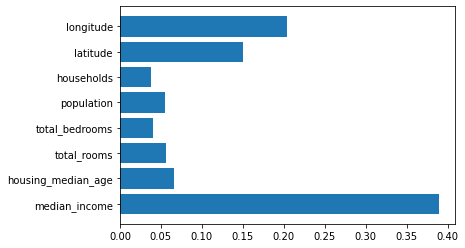

In [7]:
# plot feature importance
import matplotlib.pyplot as plt
plt.barh(X_train.columns, automl.model.estimator.feature_importances_)

In [8]:
# pickle and save the automl object
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# compute predictions of testing dataset
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels [137582.95 255519.23 139866.06 ... 185638.95 202493.78 269308.22]
True labels 14740    136900.0
10101    241300.0
20566    200700.0
2670      72500.0
15709    460000.0
           ...   
13132    121200.0
8228     137500.0
3948     160900.0
8522     227300.0
16798    265600.0
Name: median_house_value, Length: 5160, dtype: float64


In [10]:
# compute different metric values on testing dataset
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

r2 = 0.8439648010782455
mse = 2062552297.637671
mae = 30303.196010098716


In [11]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

for config in config_history:
    print(config)

{'Current Learner': 'xgboost', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'xgboost', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'xgboost', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.26208115308159446, 'learning_rate': 0.25912534572860485, 'subsample': 0.9266743941610592, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0013933617380144255, 'reg_lambda': 0.18096917948292954}, 'Best Learner': 'xgboost', 'Best Hyper-paramet

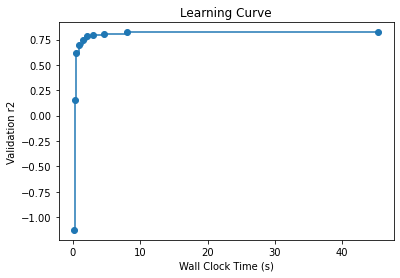

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with untuned XGBoost

### FLAML's accuracy

In [13]:
print('flaml (120s) r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

flaml (120s) r2 = 0.8439648010782455


### Default XGBoost

In [14]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [15]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
y_pred = xgb.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default xgboost r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

default xgboost r2 = 0.8265451174596482


## 4. Add customized XGBoost learners in FLAML
You can easily enable a custom objective function by adding a customized XGBoost learner (inherit XGBoostEstimator or XGBoostSklearnEstimator) in FLAML. In the following example, we show how to add such a customized XGBoost learner with a custom objective function. 

In [17]:
import numpy as np 

# define your customized objective function
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds)) # transform raw leaf weight
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess

# create customized XGBoost learners class with your objective function
from flaml.model import XGBoostEstimator


class MyXGB1(XGBoostEstimator):
    "XGBoostEstimator with the logregobj function as the objective function"

    def __init__(self, **config):
        super().__init__(objective=logregobj, **config) 


class MyXGB2(XGBoostEstimator):
    """XGBoostEstimator with 'reg:squarederror' as the objective function"""

    def __init__(self, **config):
        super().__init__(objective='reg:gamma', **config)


from flaml import AutoML
automl = AutoML()
automl.add_learner(learner_name='my_xgb1', learner_class=MyXGB1)
automl.add_learner(learner_name='my_xgb2', learner_class=MyXGB2)
settings = {
    "time_budget": 30,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['my_xgb1', 'my_xgb2'],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment_my_xgb.log',  # flaml log file
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 11-23 01:30:27] {1861} INFO - task = regression
[flaml.automl: 11-23 01:30:27] {1863} INFO - Data split method: uniform
[flaml.automl: 11-23 01:30:27] {1867} INFO - Evaluation method: holdout
[flaml.automl: 11-23 01:30:27] {1933} INFO - Minimizing error metric: 1-r2
[flaml.automl: 11-23 01:30:27] {1985} INFO - List of ML learners in AutoML Run: ['my_xgb1', 'my_xgb2']
[flaml.automl: 11-23 01:30:27] {2223} INFO - iteration 0, current learner my_xgb1
[flaml.automl: 11-23 01:30:27] {2337} INFO - Estimated sufficient time budget=341s. Estimated necessary time budget=0s.
[flaml.automl: 11-23 01:30:27] {2417} INFO -  at 0.1s,	estimator my_xgb1's best error=1.7590,	best estimator my_xgb1's best error=1.7590
[flaml.automl: 11-23 01:30:27] {2223} INFO - iteration 1, current learner my_xgb1
[flaml.automl: 11-23 01:30:27] {2417} INFO -  at 0.1s,	estimator my_xgb1's best error=0.7534,	best estimator my_xgb1's best error=0.7534
[flaml.automl: 11-23 01:30:27] {2223} INFO - iteration 2,

In [18]:
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

y_pred = automl.predict(X_test)
print(f'Predicted labels\n{y_pred}')
print(f'True labels\n{y_test}')

from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

Best hyperparmeter config: {'n_estimators': 28, 'max_leaves': 182, 'max_depth': 0, 'min_child_weight': 0.001, 'learning_rate': 0.2276973644896658, 'subsample': 0.6775148384104485, 'colsample_bylevel': 0.9912902070149149, 'colsample_bytree': 1.0, 'reg_alpha': 0.07330248020902469, 'reg_lambda': 0.36054508770487687}
Best r2 on validation data: 0.6653
Training duration of best run: 0.09387 s
Predicted labels
[172378.17 248509.11 156986.72 ... 201823.47 238128.38 273842.53]
True labels
14740    136900.0
10101    241300.0
20566    200700.0
2670      72500.0
15709    460000.0
           ...   
13132    121200.0
8228     137500.0
3948     160900.0
8522     227300.0
16798    265600.0
Name: median_house_value, Length: 5160, dtype: float64
r2 = 0.6722200251197084
mse = 4332761742.09886
mae = 43937.87377986465
